NAME_1: Marco </br>
LAST-NAME_1: Introvigne</br>
STUDENT-ID_1: 10750466</br>
NAME_2: Antonio</br>
LAST-NAME_2: Urbano</br>
STUDENT-ID_2: 10527285</br>
NAME_3: Enrico</br>
LAST-NAME_3: Voltan</br>
STUDENT-ID_3: 10525467</br>
LEADERBOARD NICKNAME: I capitani della Nave</br>



# Introduction

Visual Question Answering is a research area about building a Neural Network to answer questions presented in an image and a natural language.
We first examine the questions and aswers proposed in the training set,
the questions where about identifing object, counting them, finding their relative positions and their colors. The images were simple thus don't requiring complex models.</br>


In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionResNetV2, MobileNet
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential
import gc
from keras.preprocessing.text import Tokenizer


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing
The images have been resized to a smaller size in order to keep the model simpler

In [3]:
img_h = 128
img_w = 128

The possible answers are collected in a dictionary and the output of the neural network will be the corresponding index

In [4]:
labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

num_classes = len(labels_dict)

In order to perform a correct cross validation the best choice is to split the train questions into two groups, train set and validation set. The split is done by uploading all the keys of the train questions and dividing them according to a split coefficient. (0.75)

In [5]:
import json
root_data_path = "/content/drive/MyDrive/Kaggle_3/Dataset/"

with open(root_data_path +"train_questions_annotations.json") as json_file: 
    train = json.load(json_file) 


In [6]:
len(train)

58832

In [7]:
import random

split = 0.75
keys = list(train.keys())
random.seed(1029)
random.shuffle(keys)
train_len = int(len(train)*split)

train_keys = keys[:train_len]
val_keys = keys[train_len:]

In [8]:
len(train_keys)

44124

In [9]:
len(val_keys)

14708

In [10]:
# this function comes from the Tensorflow tutorial about Image Captioning
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_h, img_w))
    return img

All the possible questions have been "tokenized". A different integer number, called token, has been assigned to each work and the questions have been converted in vectors of tokens adding a starting and an ending word and filtering the punctuation. All the vectors have also been padded in oder to have the same lenght for all the questions.

In [11]:
tokenizer = Tokenizer(num_words=5000)

qq = []
for k in keys:
  question = '<sos> ' + train[k]["question"] + ' <eos>'
  qq.append(question)

tokenizer.fit_on_texts(qq)

In [12]:
tokenized = tokenizer.texts_to_sequences(qq)
max_question_length = max(len(sentence) for sentence in tokenized)
print("Max question sentence length:", max_question_length)

tokenized = tf.keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=max_question_length)

for i,k in enumerate(keys):
  train[k]["tokenized"] = tokenized[i]
qq= None

Max question sentence length: 23


# MODEL

The model is composed by 3 parts:


*   The input image is processed by series of convolutional layers, at each step 2 convolution are performed, one with kernel size 3 and one with kernel size 5. Their results are concatenated and used as input for the next step.
At the end a Global Avarage Pooling is performed in order to project information into a vector without increasing the number of parameters of the network thus avoiding overfitting.
*   The input question is processed by three GRU, the GRU have much less params with respect to an LSTM thus are faster to train and having a max lenght for the questions of 23 it is enought to use units of size of 256.
*   The last part of the network concatenate the results of the previous parts. The layers concatenated are the output of the convolution, the output of each of the three GRU and a similarity vector computed with a sum of dot multiplication of each of the GRU output and the Convolution. The result of the concatenation is processed with 3 dense layers with Dropout and regularization to avoid overfitting.





In [13]:
######## IMAGES PIPELINE

img_inputs = tf.keras.layers.Input(shape=(img_h, img_w, 3))
conv1 = tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same")(img_inputs)
conv2 = tf.keras.layers.Conv2D(64,(5,5),activation="relu",padding="same")(img_inputs)
union = tf.keras.layers.Concatenate()([conv1, conv2])
pool = tf.keras.layers.MaxPool2D((2,2))(union)
conv1 = tf.keras.layers.Conv2D(128,(3,3),activation="relu",padding="same")(pool)
conv2 = tf.keras.layers.Conv2D(128,(5,5),activation="relu",padding="same")(pool)
union = tf.keras.layers.Concatenate()([conv1, conv2])
pool = tf.keras.layers.MaxPool2D((2,2))(union)
conv = tf.keras.layers.Conv2D(256,(3,3),activation="relu",padding="same")(pool)
pool = tf.keras.layers.MaxPool2D((2,2))(conv)

dense = tf.keras.layers.GlobalAveragePooling2D()(pool)



In [14]:
######## QUESTION PIPELINE
units = 256

question_inputs = tf.keras.Input(shape=[max_question_length]) 
embedding_layer = tf.keras.layers.Embedding(len(tokenizer.word_index) + 1,
                                            units,
                                            input_length=max_question_length)(question_inputs)

gru_output1 = tf.keras.layers.GRU(units)(embedding_layer)
gru_output2 = tf.keras.layers.GRU(units)(embedding_layer)
gru_output3 = tf.keras.layers.GRU(units)(embedding_layer)


In [15]:
######## COMBINATION PIPELINE
mult = gru_output3 * dense + gru_output2 * dense + gru_output1 * dense
norm = tf.keras.layers.BatchNormalization()(dense)
union = tf.keras.layers.Concatenate()([mult,norm, gru_output1,gru_output2,gru_output3])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 4864        input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 128 0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

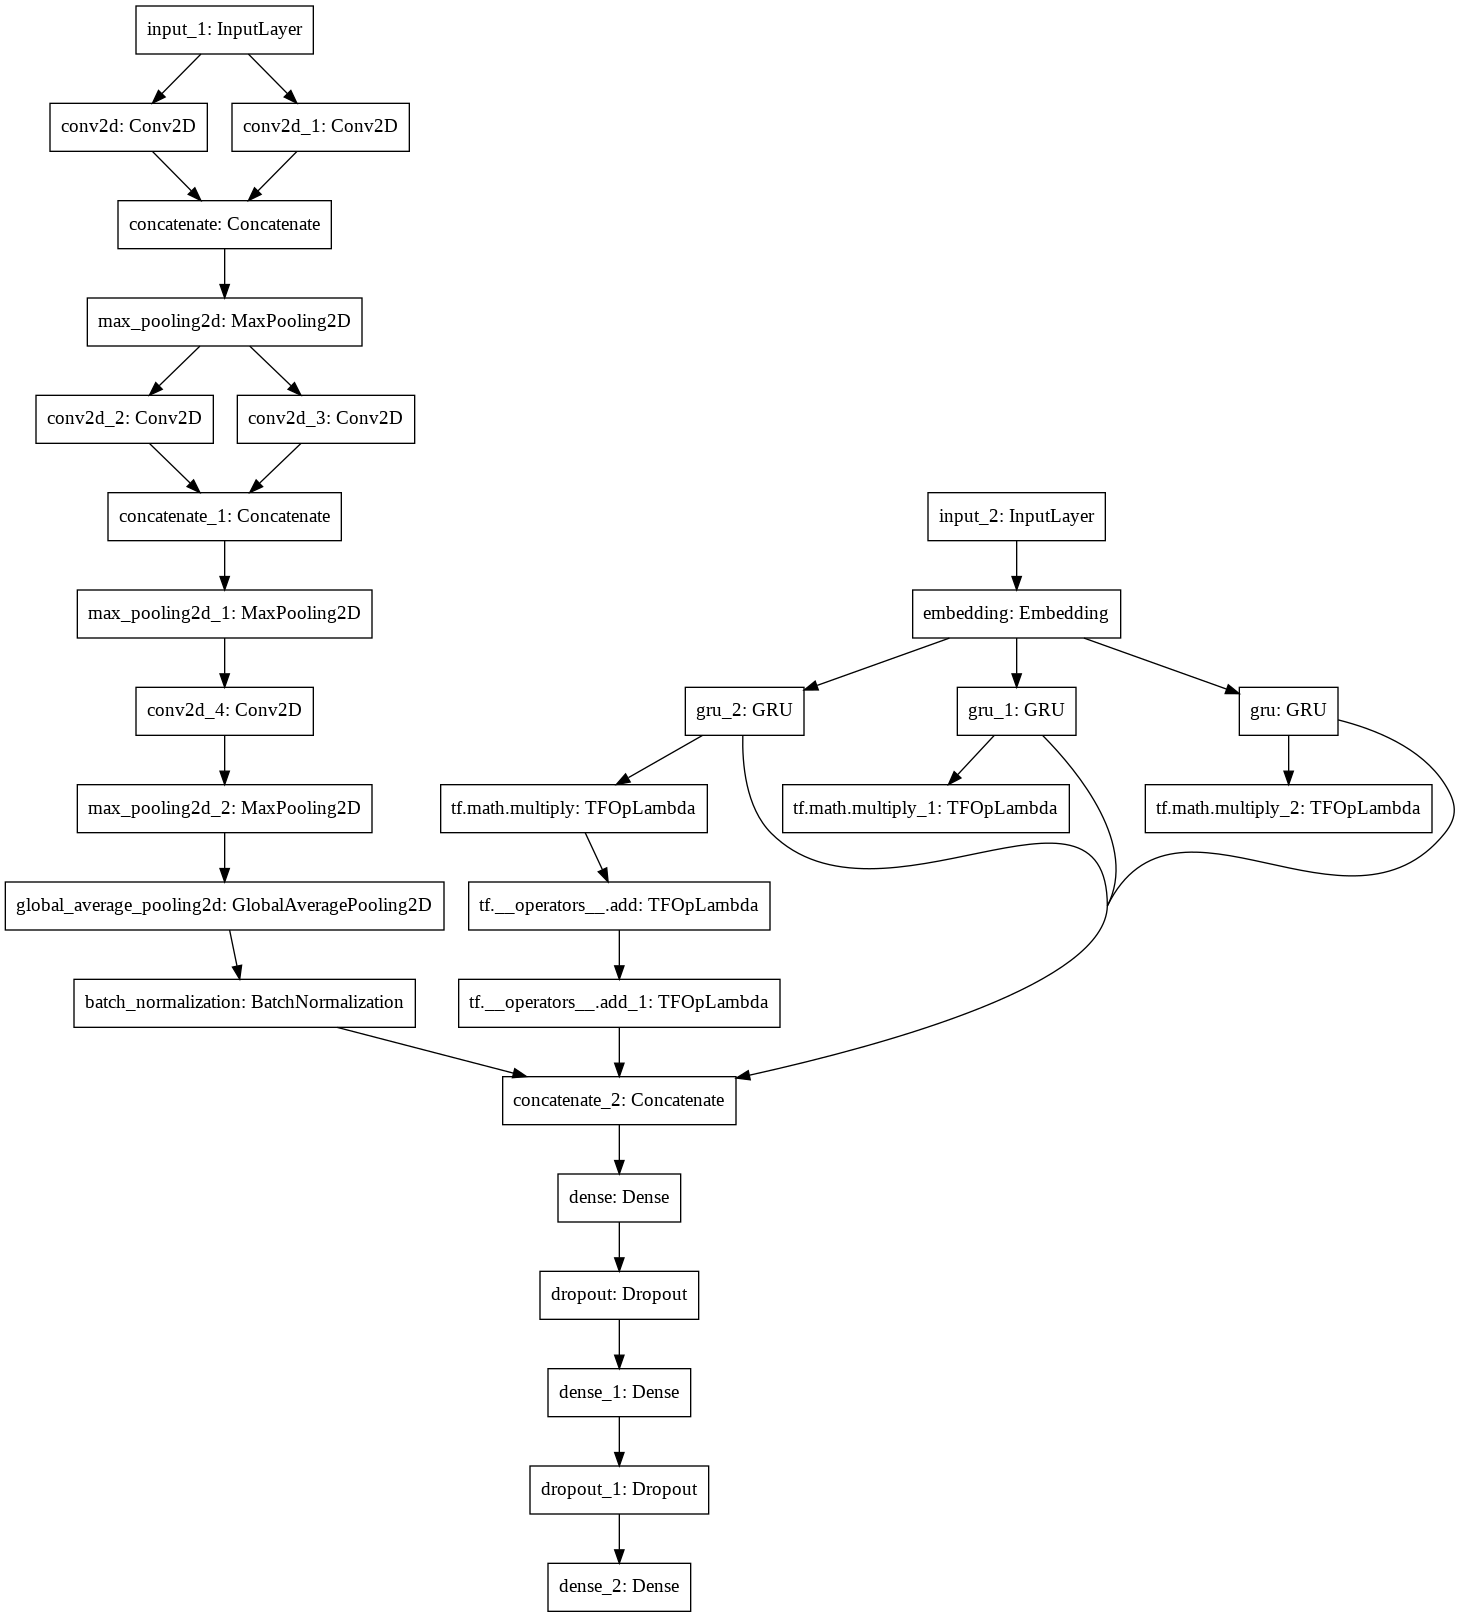

In [16]:
from keras.regularizers import l2


output = tf.keras.layers.Dense(units, activation="relu",kernel_regularizer=l2(0.01))(union)
output = tf.keras.layers.Dropout(0.2)(output)


output = tf.keras.layers.Dense(units // 4, activation="relu")(output)
output = tf.keras.layers.Dropout(0.4)(output)


output = tf.keras.layers.Dense(num_classes, activation="softmax")(output)

model = tf.keras.Model([img_inputs, question_inputs], output)

model.summary()
tf.keras.utils.plot_model(model)



In [17]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=1e-3)


model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

# TRAIN

Using directly the entire dataset is unfeasable becouse of the limited resoures. The train has been performed with the function "fit_generator" which at each step upload the data from the method passed as argument. At each step the images, questions and answers are uploaded from the disk starting from the already splitted train and validation keys.

In [18]:

def custom_generator(keys,batch_size=64,tokenizer = None):
  path = "/content/drive/MyDrive/Kaggle_3/Dataset/Images/"
    
  while True:
      gc.collect()

      keys_batch = np.random.choice(keys, size=batch_size)

      images = []
      answers = []
      questions = []

      for i,k in enumerate(keys_batch):
        
        im = load_image(path + train[k]["image_id"] + ".png")
        
        images.append(im)
        answer = train[k]["answer"]
        x = np.zeros(num_classes)
        x[labels_dict[answer]] = 1
        answers.append(x)
        questions.append(train[k]["tokenized"])

      


      train_features_X = np.array(images)
      train_questions_X = np.array(questions)
      train_ans_Y = np.array(answers)
      yield ([train_features_X, train_questions_X], train_ans_Y)

In [19]:
model.load_weights("/content/drive/MyDrive/Kaggle_3/terza_guerra1.h5")

In [21]:
batch_size = 50


early_stopping = tf.keras.callbacks.EarlyStopping(
     monitor='val_accuracy',
     verbose=1,
     patience=20,
     mode='max',
     restore_best_weights=True)

history = model.fit_generator(generator=custom_generator(train_keys, batch_size, tokenizer),
                              steps_per_epoch=len(train_keys) // 500,
                              validation_data=custom_generator(val_keys, batch_size, tokenizer),
                              validation_steps=len(val_keys) // 50,
                              epochs=200,
                              callbacks=[early_stopping])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
88/88 [==============================] - 1827s 21s/step - loss: 0.8919 - accuracy: 0.6676 - precision: 0.7834 - recall: 0.5623 - val_loss: 1.0944 - val_accuracy: 0.5914 - val_precision: 0.6770 - val_recall: 0.4935
Epoch 2/200
88/88 [==============================] - 921s 11s/step - loss: 0.8674 - accuracy: 0.6803 - precision: 0.8057 - recall: 0.5818 - val_loss: 1.0864 - val_accuracy: 0.5952 - val_precision: 0.6791 - val_recall: 0.5051
Epoch 3/200
88/88 [==============================] - 609s 7s/step - loss: 0.8802 - accuracy: 0.6732 - precision: 0.7632 - recall: 0.5784 - val_loss: 1.1427 - val_accuracy: 0.6027 - val_precision: 0.6807 - val_recall: 0.5229
Epoch 4/200
88/88 [==============================] - 499s 6s/step - loss: 0.8782 - accuracy: 0.6732 - precision: 0.7610 - recall: 0.5779 - val_loss: 1.1771 - val_accuracy: 0.5905 - val_precision: 0.6684 - val_recall: 0.5071
Epoch 5/200
88/88 [==============================] - 434s 5s/step - loss: 0.8852 - accuracy: 0.6821 -

In [22]:
model.save_weights("/content/drive/MyDrive/Kaggle_3/terza_guerra1.h5")

# PREDICTION

The prediction is performed in the same way as the training. The main difference is that this time it is possible to upload all the data from the disk and compute the prediction directly.

In [23]:
with open(root_data_path +"test_questions.json") as json_file: 
    test = json.load(json_file)

keys = list(test.keys())

In [24]:
qq = []
for k in keys:
  question = '<sos> ' + test[k]["question"] + ' <eos>'
  qq.append(question)

tokenized = tokenizer.texts_to_sequences(qq)


tokenized = tf.keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=max_question_length)

for i,k in enumerate(keys):
  test[k]["tokenized"] = tokenized[i]
qq= None

In [25]:
def createTestSets():
  path = "/content/drive/MyDrive/Kaggle_3/Dataset/Images/"
    
  gc.collect()
  images = []
  answers = []
  questions = []
  import tqdm
  import time

  for i,k in tqdm.tqdm(enumerate(keys), total = len(keys)):
    
    im = load_image(path + test[k]["image_id"] + ".png")
    
    images.append(im)
    questions.append(test[k]["tokenized"])

  train_features_X = np.array(images)
  train_questions_X = np.array(questions)
  return [train_features_X, train_questions_X]

In [26]:
testSet = createTestSets()
answers = model.predict(testSet)

100%|██████████| 6372/6372 [03:37<00:00, 29.32it/s]


In [27]:
answer_indexes = tf.argmax(answers, -1)
answer_indexes = np.array(answer_indexes)
answer_indexes

array([49, 15,  2, ...,  2, 57, 55])

In [28]:
results = {}
for i,k in enumerate(keys):
  results[k] = answer_indexes[i]

In [29]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [30]:
create_csv(results,"")